In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import numpy as np

In [3]:
import tensorflow as tf
import tensorflow_hub as hub

In [4]:
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Input, Dense, Lambda, Activation, Conv1D, \
                                    MaxPooling1D, Flatten, Reshape, Bidirectional, \
                                    BatchNormalization, Dropout, add, LSTM, \
                                    TimeDistributed
from tensorflow.keras.optimizers import RMSprop, Adam, Adamax, SGD
from tensorflow.keras.regularizers import l2

In [5]:
from src.keras_bert import convert_single_example, \
                           convert_text_to_examples, \
                           create_tokenizer_from_hub_module, \
                           convert_examples_to_features, \
                           InputExample, \
                           initialize_vars, \
                           BertLayer

In [6]:
from sklearn.metrics import classification_report
from sklearn.metrics import f1_score as scikit_f1_score

In [7]:
# Initialize session
sess = tf.compat.v1.Session()

In [8]:
with tf.device("gpu:0"):
    print("GPU enabled")

GPU enabled


#### Custom Functions

In [9]:
from src.callbacks import PlotCurvesTF as PlotCurves
from src.eval_metrics import f1_macro, f1_micro 
from src.load_data import load_data

Using TensorFlow backend.


### Load Data

In [10]:
train_data, valid_data, test_data, metadata = load_data()

### Load BERT

In [11]:
BERT_PATH = "https://tfhub.dev/google/bert_uncased_L-12_H-768_A-12/1"

In [12]:
bert = hub.Module(BERT_PATH, trainable=True)

### Prepare data

In [13]:
ww = 1
n_tags = 2
batch_size = 2

max_seq_length = 512
if max_seq_length > 512:
    print('!!!!!!! WARNING: BERT does not accept length > 512')
    max_seq_length = 512

In [14]:
def get_padding_sentence(max_seq_length, padding_text='ENDPAD'):
    
    tokenizer = create_tokenizer_from_hub_module(BERT_PATH)

    example_sent = InputExample(guid=None, text_a=" ".join(padding_text), text_b=None, label=0)

    (input_ids, input_mask, segment_ids, label) = \
            convert_single_example(tokenizer, example_sent, max_seq_length=max_seq_length)
    
    return {"input_ids":input_ids, "input_mask":input_mask, "segment_ids":segment_ids, "label":0}

In [41]:
def get_input(data_, ww, max_seq_length, batch_size, limit=None):
    
    padding_sent = get_padding_sentence(max_seq_length, padding_text='ENDPAD')
    
    tokenizer = create_tokenizer_from_hub_module(BERT_PATH)

    X = []
    y = []
    for article in data_:
        
        X_art = np.array([[" ".join(sentence['sentence'].replace('\n', ' ').strip().split()[0:max_seq_length])] 
                      for sentence in article['sentences']], dtype=object)
        
        y_art = [sentence['label'] for sentence in article['sentences']]
        
        examples_ = convert_text_to_examples(X_art, y_art)
        
        (input_ids, input_masks, segment_ids, labels_) = \
            convert_examples_to_features(tokenizer, examples_, max_seq_length=max_seq_length)
        
        for si, _ in enumerate(article['sentences']):
            
            input_ids_seq = []
            input_mask_seq = []
            segment_ids_seq = []
            y_seq = []

            # Prev
            for i in reversed(range(ww)):
                
                if si-i-1 >= 0:
                    sent_obj_prev = {"input_ids": input_ids[si-i-1], 
                                     "input_mask": input_masks[si-i-1],
                                     "segment_ids": segment_ids[si-i-1]}
                else:    
                    sent_obj_prev = padding_sent

                input_ids_seq.append(sent_obj_prev['input_ids'])
                input_mask_seq.append(sent_obj_prev['input_mask'])
                segment_ids_seq.append(sent_obj_prev['segment_ids'])

            # Curr
            sent_obj = {"input_ids": input_ids[si], 
                        "input_mask": input_masks[si],
                        "segment_ids": segment_ids[si]} 
             
            input_ids_seq.append(sent_obj['input_ids'])
            input_mask_seq.append(sent_obj['input_mask'])
            segment_ids_seq.append(sent_obj['segment_ids'])
            y_seq.append(labels_[si][0])
            
            # Next
            for i in range(ww):
                
                if si+i+1 < len(article['sentences']):
                    sent_obj_next = {"input_ids": input_ids[si+i+1], 
                                     "input_mask": input_masks[si+i+1],
                                     "segment_ids": segment_ids[si+i+1]}
                else:
                    sent_obj_next = padding_sent
                    
                input_ids_seq.append(sent_obj_next['input_ids'])
                input_mask_seq.append(sent_obj_next['input_mask'])
                segment_ids_seq.append(sent_obj_next['segment_ids'])

            X_seq = (np.array(input_ids_seq),
                     np.array(input_mask_seq),
                     np.array(segment_ids_seq))

            X.append(X_seq)
            y.append(y_seq)
            
    # limit data if not an even number when batch_size=2
    if not limit:
        limit = len(X) if len(X)%batch_size == 0 else len(X)-len(X)%batch_size
        X = X[:limit]
        y = y[:limit]
            
    return np.array(X), np.array(y)

In [42]:
X_tra, y_tra = get_input(train_data, ww, max_seq_length, batch_size, limit=None)
X_val, y_val = get_input(valid_data, ww, max_seq_length, batch_size, limit=None)

Converting examples to features: 100%|██████████| 32/32 [00:00<00:00, 2193.06it/s]


Converting examples to features: 100%|██████████| 10/10 [00:00<00:00, 2527.15it/s]


In [43]:
X_tra.shape, X_val.shape

((3582, 3, 3, 512), (398, 3, 3, 512))

In [44]:
y_tra.shape, y_val.shape

((3582, 1), (398, 1))

In [45]:
# Check if padding sentences are equal
padset = get_padding_sentence(max_seq_length, padding_text='ENDPAD')
padset['input_ids'] == list(X_tra[0][0][0])

True

## Build Model

In [28]:
def BERTEmbeddingStack(x):
    embeds = []
    for art in tf.unstack(tf.reshape(x, (batch_size, 3, 2*ww+1, 512))):
        art = tf.cast(art, dtype="int32")
        # Below does not change the shape of segment_ids etc.
        # Only puts them into a dictionary
        bert_inputs = dict(
            input_ids=art[0], 
            input_mask=art[1], 
            segment_ids=art[2]
        )
        # Mean-Pooling
        result = bert(bert_inputs, signature="tokens", as_dict=True)["sequence_output"]
        mul_mask = lambda x, m: x * tf.expand_dims(m, axis=-1)
        masked_reduce_mean = lambda x, m: tf.reduce_sum(mul_mask(x, m), axis=1) / (
                             tf.reduce_sum(m, axis=1, keepdims=True) + 1e-10)
        input_mask = tf.cast(art[1], tf.float32)
        pooled = masked_reduce_mean(result, input_mask)
        embeds.append(pooled)
    print(tf.stack(embeds, 0))
    return tf.stack(embeds, 0)

In [46]:
def build_model_0(ww):
    
    inp_size = 2*ww+1
    input_text = Input(shape=(3, inp_size, max_seq_length))
    
    bert_output = Lambda(BERTEmbeddingStack, output_shape=(None, None, inp_size, 768))(input_text)
    
    x = Bidirectional(LSTM(units=256, return_sequences=True))(bert_output)
                      
    pred = LSTM(1, activation="sigmoid")(x)

    return Model(inputs=[input_text], outputs=pred)

def build_model_1(ww):
    
    inp_size = 2*ww+1
    input_text = Input(shape=(3, inp_size, max_seq_length))
    
    bert_output = Lambda(BERTEmbeddingStack, output_shape=(None, None, inp_size, 768))(input_text)
    
    x = Bidirectional(LSTM(units=128, return_sequences=True))(bert_output)

    pred = LSTM(1, activation="sigmoid")(x)

    return Model(inputs=[input_text], outputs=pred)

def build_model_2(ww):
    
    inp_size = 2*ww+1
    input_text = Input(shape=(3, inp_size, max_seq_length))
    
    bert_output = Lambda(BERTEmbeddingStack, output_shape=(None, None, inp_size, 768))(input_text)
    
    x = Bidirectional(LSTM(units=256, return_sequences=True))(bert_output)
    x = Dropout(0.2)(x)
                      
    pred = LSTM(1, activation="sigmoid")(x)

    return Model(inputs=[input_text], outputs=pred)

def build_model_3(ww):
    
    inp_size = 2*ww+1
    input_text = Input(shape=(3, inp_size, max_seq_length))
    
    bert_output = Lambda(BERTEmbeddingStack, output_shape=(None, None, inp_size, 768))(input_text)
    
    x = Dense(256, kernel_regularizer=l2(0.001))(bert_output)
    x = Activation('relu')(x)
    
    x = Bidirectional(LSTM(units=128, return_sequences=True))(x)

    pred = LSTM(1, activation="sigmoid")(x)

    return Model(inputs=[input_text], outputs=pred)

def build_model_4(ww):
    
    inp_size = 2*ww+1
    input_text = Input(shape=(3, inp_size, max_seq_length))
    
    bert_output = Lambda(BERTEmbeddingStack, output_shape=(None, None, inp_size, 768))(input_text)
    
    x = Dense(256, kernel_regularizer=l2(0.001))(bert_output)
    x = Activation('relu')(x)
    
    x = Bidirectional(LSTM(units=128, return_sequences=True, recurrent_dropout=0.2, dropout=0.2))(x)

    pred = LSTM(1, activation="sigmoid")(x)

    return Model(inputs=[input_text], outputs=pred)


def build_model_6(ww):
    
    inp_size = 2*ww+1
    input_text = Input(shape=(3, inp_size, max_seq_length))
    
    bert_output = Lambda(BERTEmbeddingStack, output_shape=(None, None, inp_size, 768))(input_text)
    
    x = Bidirectional(LSTM(units=256, return_sequences=True))(bert_output)
    x = Bidirectional(LSTM(units=128, return_sequences=True))(x)
    x = Dropout(0.4)(x)
    
    pred = LSTM(1, activation="sigmoid")(x)

    return Model(inputs=[input_text], outputs=pred)

def build_model_8(ww):
    
    def residual(x):
        x_res = x
        
        x = Bidirectional(LSTM(units=128, return_sequences=True))(x)
        x = add([x, x_res])
        return x
    
    inp_size = 2*ww+1
    input_text = Input(shape=(3, inp_size, max_seq_length))
    
    bert_output = Lambda(BERTEmbeddingStack, output_shape=(None, None, inp_size, 768))(input_text)
    
    x = Bidirectional(LSTM(units=128, return_sequences=True))(bert_output)
    x = residual(x)

    pred = LSTM(1, activation="sigmoid")(x)

    return Model(inputs=[input_text], outputs=pred)

def build_model_11(ww):
    
    def residual(x):
        x_res = x
        
        x = Bidirectional(LSTM(units=128, return_sequences=True))(x)
        x = add([x, x_res])
        return x
    
    inp_size = 2*ww+1
    input_text = Input(shape=(3, inp_size, max_seq_length))
    
    bert_output = Lambda(BERTEmbeddingStack, output_shape=(None, None, inp_size, 768))(input_text)
    
    x = Dense(256, kernel_regularizer=l2(0.001))(bert_output)
    x = Activation('relu')(x)

    x = Bidirectional(LSTM(units=128, return_sequences=True))(embedding)
    x = residual(x)

    pred = LSTM(1, activation="sigmoid")(x)

    return Model(inputs=[input_text], outputs=pred)

def build_model_12(ww):
    
    def residual(x):
        x_res = x

        x = Bidirectional(CuDNNLSTM(units=256, return_sequences=True))(x)
        x = add([x, x_res])
        return x

    inp_size = 2*ww+1
    input_text = Input(shape=(3, inp_size, max_seq_length))
    
    bert_output = Lambda(BERTEmbeddingStack, output_shape=(None, None, inp_size, 768))(input_text)
    
    x = Dense(256, kernel_regularizer=l2(0.001))(bert_output)
    x = Activation('relu')(x)
                                
    x = Bidirectional(LSTM(units=256, return_sequences=True))(x)
    x = residual(x)

    pred = LSTM(1, activation="sigmoid")(x)

    return Model(inputs=[input_text], outputs=pred)

def build_model_13(ww):
    
    def residual(x):
        x_res = x
        
        x = Bidirectional(LSTM(units=128, return_sequences=True,
                           recurrent_dropout=0.2, dropout=0.2))(x)

        x = add([x, x_res])
        return x
    
    inp_size = 2*ww+1
    input_text = Input(shape=(3, inp_size, max_seq_length))
    
    bert_output = Lambda(BERTEmbeddingStack, output_shape=(None, None, inp_size, 768))(input_text)  
    
    x = Dense(256, kernel_regularizer=l2(0.001))(bert_output)
    x = Activation('relu')(x)

    x = Bidirectional(LSTM(units=128, return_sequences=True,
                           recurrent_dropout=0.2, dropout=0.2))(x)

    x = residual(x)

    pred = LSTM(1, activation="sigmoid")(x)
    
    return Model(inputs=[input_text], outputs=pred)

In [30]:
learningrate = 2e-5
optimizer = Adam(lr=learningrate)
optimizer_str = 'adam'
loss = 'binary_crossentropy'
metrics = ['acc', f1_macro, f1_micro]

In [31]:
model = build_model_2(ww)
model.summary()

model.compile(loss=loss, optimizer=optimizer, metrics=metrics)

W1110 15:01:14.035214 140499060060288 deprecation.py:506] From /home/aorus/workspaces/simge/Master_Thesis/.env/lib/python3.6/site-packages/tensorflow/python/ops/init_ops.py:1251: calling VarianceScaling.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
W1110 15:01:14.038515 140499060060288 deprecation.py:506] From /home/aorus/workspaces/simge/Master_Thesis/.env/lib/python3.6/site-packages/tensorflow/python/ops/init_ops.py:97: calling GlorotUniform.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
W1110 15:01:14.039088 140499060060288 deprecation.py:506] From /home/aorus/workspaces/simge/Master_Thesis/.env/lib/python3.6/site-packag

Tensor("lambda_2/stack:0", shape=(2, 3, 768), dtype=float32)
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 3, 3, 512)]       0         
_________________________________________________________________
lambda_2 (Lambda)            (2, 3, 768)               0         
_________________________________________________________________
bidirectional (Bidirectional (2, 3, 512)               2099200   
_________________________________________________________________
dropout (Dropout)            (2, 3, 512)               0         
_________________________________________________________________
lstm_1 (LSTM)                (2, 1)                    2056      
Total params: 2,101,256
Trainable params: 2,101,256
Non-trainable params: 0
_________________________________________________________________


In [32]:
model_name = 'RQ2_test_bert_many_to_one_model_2' + \
             '_ww_' + str(ww) + \
             '_' + optimizer_str + \
             '_lr_' + str(learningrate) + \
             '_lrreduction' + \
             '_loss_' + loss

model_dir = './Model/' + model_name.split('model')[0] + 'model/' + model_name
results_file = os.path.join(model_dir, 'model_results_file.txt')

### Train Model

In [33]:
# Instantiate variables
initialize_vars(sess)

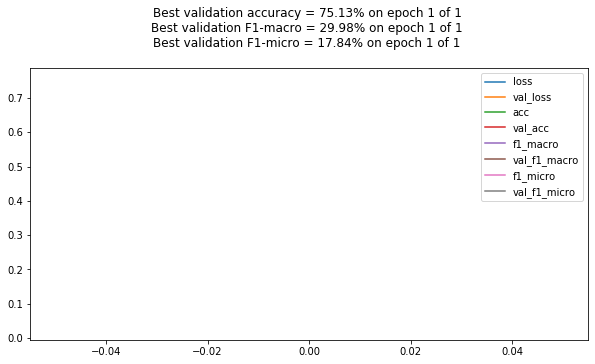

3582/3582 [==============================] - 322s 90ms/sample - loss: 0.5492 - acc: 0.7236 - f1_macro: 0.0534 - f1_micro: 0.0310 - val_loss: 0.5171 - val_acc: 0.7513 - val_f1_macro: 0.2998 - val_f1_micro: 0.1784


In [34]:
model.fit(X_tra, y_tra, 
          epochs=1,
          batch_size=batch_size, 
          validation_data=(X_val, y_val),
          callbacks=[
            PlotCurves(model_name=model_name, 
                       model_dir=model_dir, jnote=True)
          ])

### Load the best Model

In [35]:
model_name

'RQ2_test_bert_many_to_one_model_2_ww_1_adam_lr_2e-05_lrreduction_loss_binary_crossentropy'

In [36]:
best_model = model

### Evaluation

In [37]:
def get_scores(model, data_, batch_size, ww, max_seq_length,
               results_file=None, print_out=False):
    
    X, y_true = get_input(data_, ww, max_seq_length, batch_size, limit=None)
    y_true = [y[0] for y in y_true]
    
    y_preds = model.predict(X, batch_size=batch_size)
    y_preds = [0 if y[0] < 0.5 else 1 for y in y_preds]
    
    clsrpt = classification_report(y_true, y_preds)
    sf1 = scikit_f1_score(y_true, y_preds)
    sfm = scikit_f1_score(y_true, y_preds, average='macro')

    if print_out:
        print(clsrpt)
        print('\nScikit_F1_Macro:', sfm)
        print('\nScikit_F1_1:', sf1)

    if results_file:
        with open(results_file, 'a') as f:
            f.write('\n' + clsrpt + '\nF1_Macro: ' + str(sfm) + '\nF1_1: ' + str(sf1) + '\n\n')
            
    return sfm

#### Validation Set

In [38]:
with open(results_file, 'w') as f:
    f.write('\n---------------- Validation ----------------\n')
val_f1 = get_scores(best_model, valid_data, batch_size, ww, max_seq_length, 
                    results_file, print_out=True)

Converting examples to features: 100%|██████████| 10/10 [00:00<00:00, 2474.81it/s]


              precision    recall  f1-score   support

           0       0.79      0.85      0.82       268
           1       0.64      0.55      0.59       130

   micro avg       0.75      0.75      0.75       398
   macro avg       0.72      0.70      0.71       398
weighted avg       0.74      0.75      0.75       398


Scikit_F1_Macro: 0.7054166199394414

Scikit_F1_1: 0.5892116182572613


#### Test Set

In [39]:
with open(results_file, 'a') as f:
    f.write('\n---------------- Test ----------------\n')
test_f1 = get_scores(best_model, test_data, batch_size, ww, max_seq_length,
                     results_file, print_out=True)

Converting examples to features: 100%|██████████| 13/13 [00:00<00:00, 2080.83it/s]


              precision    recall  f1-score   support

           0       0.81      0.94      0.87       325
           1       0.68      0.37      0.48       115

   micro avg       0.79      0.79      0.79       440
   macro avg       0.75      0.66      0.68       440
weighted avg       0.78      0.79      0.77       440


Scikit_F1_Macro: 0.6760459681807997

Scikit_F1_1: 0.4831460674157303
